# Complete Example

The subcomponents are all joined together into the main flasher class, which combines the superancillary to first check the phase, followed by K-D tree lookup for the best starting point, and finally Newton iteration to get the correct temperature and density

In [1]:
import timeit, json, functools

import teqpflsh, teqp 
import CoolProp

import numpy as np
import matplotlib.pyplot as plt

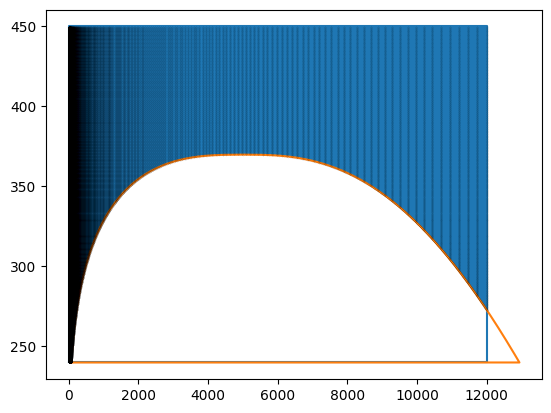

In [2]:
name = "n-Propane"

j = json.load(open('PROPANE_exps.json'))
sa = teqpflsh.SuperAncillary(json.dumps(j))
import CoolProp.CoolProp as CP
AS = CP.AbstractState('HEOS', 'n-Propane')
def calc(T, rho, AS, key):
    AS.specify_phase(CP.iphase_gas)
    AS.update(CP.DmolarT_INPUTS, rho, T)
    val = AS.keyed_output(key)
    AS.unspecify_phase()
    return val
sa.add_variable(k='H', caller=functools.partial(calc, AS=AS, key=CP.iHmolar))
sa.add_variable(k='S', caller=functools.partial(calc, AS=AS, key=CP.iSmolar))
sa.add_variable(k='U', caller=functools.partial(calc, AS=AS, key=CP.iUmolar))
Tcrit = sa.get_approx1d(k='D', q=1).xmax

path = f'{teqp.get_datapath()}/dev/fluids/{name}.json'
jresid = {"kind": "multifluid", "model": {"components": [name], "root": teqp.get_datapath()}}
jidealgas = {"kind": "IdealHelmholtz", "model": [teqp.convert_CoolProp_idealgas(path, 0)]}
rf = teqpflsh.RegionedFlasher(
    ideal_gas=json.dumps(jidealgas), 
    resid=json.dumps(jresid), 
    mole_fractions=np.array([1.0])
)

# Now we make a region with rectangular shape in T, rho coordinates with only its 5 corners
Tmin = 240 # K
Tmax = 450 # K
rhomin = 1e-6 # mol/m³
rhomax = 12000 # mol/m³
Tpoly = np.array([Tmin, Tmin, Tmax, Tmax, Tmin])
rhopoly = np.array([rhomin, rhomax, rhomax, rhomin, rhomin])

def makeVLE(Trange):
    x, y = [], []
    for T in Trange:
        x.append(sa.get_yval(T=float(T), q=1.0, k='D')); y.append(T)
    for T in reversed(Trange):
        x.append(sa.get_yval(T=float(T), q=0.0, k='D')); y.append(T)
    return np.array(x), np.array(y)

ptr = teqpflsh.GeometryFactoryHolder()
box = ptr.makeclosedpolygon(rhopoly, Tpoly)
VLE = ptr.makeclosedpolygon(*makeVLE(np.linspace(Tmin, Tcrit, 1000)))
rhoreg, Treg = box.difference(VLE).getXY()

NT = 1000
Nrho = 1000
rf.add_region(T=Treg, rho=rhoreg, NT=NT, Nrho=Nrho)
for reg in rf.get_regions_rw():
    reg.add_pair(proppair=teqpflsh.PropertyPairs.PS, Nsplit=5)
    reg.add_pair(proppair=teqpflsh.PropertyPairs.ST, Nsplit=5)

# Build the helper class holding the models for ideal gas and residual Helmholtz energy
helm = teqpflsh.teqpHelmholtzInterface(ideal_gas=json.dumps(jidealgas), residual=json.dumps(jresid))

# Build the main flasher which includes all the parts
mf = teqpflsh.MainFlasher(regions=rf, superancillary=sa, helm=helm)

# Plot the region that is being mapped
plt.plot(*box.getXY())
plt.plot(*VLE.getXY())
plt.fill(rhoreg, Treg)
reg = mf.regioned_flasher.get_regions_ro()[0]
propset = reg.propset_Trhogrid
plt.plot(propset.rho, propset.T, 'k.', ms=0.05)

In [3]:
reg = mf.regioned_flasher.get_regions_ro()[0]
propset = reg.propset_Trhogrid

val1 = propset.p
val2 = propset.s + np.random.random(val1.shape)
T = np.zeros_like(val1)
rho = np.zeros_like(val1)
q = np.zeros_like(val1)
print(len(val1))

tic = timeit.default_timer()
mf.flash_many(teqpflsh.PropertyPairs.PS, val1, val2, T, rho, q)
toc = timeit.default_timer()
print((toc-tic)/len(val1)*1e6, 'μs per flash call')

907865
3.4448237535615216 μs per flash call


In [4]:
reg = mf.regioned_flasher.get_regions_ro()[0]
propset = reg.propset_Trhogrid

val1 = propset.s + np.random.random(val1.shape)
val2 = propset.T
T = np.zeros_like(val1)
rho = np.zeros_like(val1)
q = np.zeros_like(val1)

tic = timeit.default_timer()
mf.flash_many(teqpflsh.PropertyPairs.ST, val1, val2, T, rho, q)
toc = timeit.default_timer()
print((toc-tic)/len(val1)*1e6, 'μs per flash call')

2.295959200958003 μs per flash call
